# Importing Training Data
First we mount our drive as it contains all the training validating and testing data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Then we need to change directory to the one where we have our training data stored, in my case its in:
> My Drive > math-vision >





In [ ]:
%cd /content/drive/My Drive/math-vision/

/content/drive/My Drive/math-vision


Now we need to unzip this file so that we can utilise ImageDataGenerator to load images for training our model.

In [ ]:
!unzip images.zip -d /content/

This is a one time only thing if you plan on unzipping this in your google drive.

# Importing required modules

In [55]:
!pip install scikit-learn
!pip install tensorflow_addons
!pip install opencv-python
!pip install pandas
!pip install matplot
!pip install tqdm
!pip install Pillow
!pip install scipy

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend
from tensorflow import keras
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau

Setting memory growth to max.

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(20)
tf.config.threading.set_intra_op_parallelism_threads(20)
# Check GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)



1 Physical GPUs, 1 Logical GPUs


# Initializing Paths
This will help us initialize paths to our data.

In [5]:
# Base Path
BASE_DIR = 'images/'

# Dir to our Base Path
DATASET = os.path.join(BASE_DIR, 'dataset/')

# Fine tune Dir
FINE_DATASET = os.path.join(BASE_DIR, 'fine_tune_dataset/')


Validating our data structure.

In [4]:
# Verify the directory structure
def verify_directory_structure(base_dir):
    file_tally = 0
    for root, dirs, files in os.walk(base_dir):
        print(f'Root: {root}, Number of files: {len(files)}')
        file_tally += len(files)
    return file_tally

# Verify the training, validation, and testing directories
print('Training directory structure:')
data = verify_directory_structure(DATASET)

Training directory structure:
Root: images/dataset/, Number of files: 0
Root: images/dataset/100, Number of files: 11069
Root: images/dataset/101, Number of files: 25523
Root: images/dataset/102, Number of files: 3453
Root: images/dataset/103, Number of files: 4579
Root: images/dataset/104, Number of files: 9630
Root: images/dataset/105, Number of files: 3617
Root: images/dataset/106, Number of files: 2788
Root: images/dataset/107, Number of files: 3383
Root: images/dataset/108, Number of files: 16210
Root: images/dataset/109, Number of files: 3537
Root: images/dataset/110, Number of files: 12310
Root: images/dataset/111, Number of files: 3641
Root: images/dataset/112, Number of files: 3340
Root: images/dataset/113, Number of files: 3886
Root: images/dataset/114, Number of files: 14997
Root: images/dataset/115, Number of files: 3591
Root: images/dataset/116, Number of files: 19154
Root: images/dataset/117, Number of files: 3722
Root: images/dataset/118, Number of files: 3802
Root: imag

Let's see how much data do we possess.

In [5]:

print('Total number of images in the dataset:', data)


Total number of images in the dataset: 824416


The data I managed to gather is following:

> Total number of training images: 824,416

We will however split the total images in dataset directory for training and validation sets.

This data above comprises of EMNIST BY CLASS and special characters that I managed to synthetically generate.

Let's now look at our fine tuning dataset that I managed to gather from kaggle.

In [6]:
print('Fine tuning directory structure:')
data = verify_directory_structure(FINE_DATASET)

Fine tuning directory structure:
Root: images/fine_tune_dataset/, Number of files: 0
Root: images/fine_tune_dataset/100, Number of files: 1074
Root: images/fine_tune_dataset/101, Number of files: 2962
Root: images/fine_tune_dataset/102, Number of files: 608
Root: images/fine_tune_dataset/103, Number of files: 760
Root: images/fine_tune_dataset/104, Number of files: 990
Root: images/fine_tune_dataset/105, Number of files: 2035
Root: images/fine_tune_dataset/106, Number of files: 427
Root: images/fine_tune_dataset/107, Number of files: 557
Root: images/fine_tune_dataset/108, Number of files: 1415
Root: images/fine_tune_dataset/109, Number of files: 879
Root: images/fine_tune_dataset/110, Number of files: 1906
Root: images/fine_tune_dataset/111, Number of files: 2048
Root: images/fine_tune_dataset/112, Number of files: 786
Root: images/fine_tune_dataset/113, Number of files: 427
Root: images/fine_tune_dataset/114, Number of files: 1708
Root: images/fine_tune_dataset/115, Number of files: 

In [7]:
print('Total number of images in the fine tuning dataset:', data)

Total number of images in the fine tuning dataset: 130472


The data I managed to gather for fine tuning:

> Total number of training images: 130,472

Credit goes to various handwriting datasets on kaggle coversing alphabets and mathematical symbols.

# Character Mapping


In [6]:
def ascii_convert(ascii_code):
    return chr(int(ascii_code))

Our goal is to unmap characters like so

```
# Example usage
if mapping => [1, 27, 53]
then 1' -> 'a' , 27 -> 'A' ,  53 -> '1'
```


We need a decoder to translate it back to english.

In [7]:
def decode_label(encoded_label, char_to_num):
    """
    Decodes a single encoded label to its corresponding character.
    """
    num_to_char = {v: k for k, v in char_to_num.items()}
    return num_to_char[encoded_label]

# Initializing Data Provider

Lets define parameters for our model training.

In [3]:
# Define your parameters

BATCH_SIZE = 64

TARGET_SIZE = (140,140)

VAL_SPLIT = 0.20

First we need to define an augmentor that we will utilise in our custom data provider.

In [8]:
# training data

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VAL_SPLIT,
    rotation_range=8,
    width_shift_range=0.12,
    height_shift_range=0.05,
    shear_range=2,
    fill_mode='nearest',
    brightness_range=(0.9,1.3),
)

val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=VAL_SPLIT,)

Creating training, testing and validation generators.

In [9]:
# Create the generator

train_generator = datagen.flow_from_directory(
    DATASET,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    color_mode='grayscale',
    subset='training', # Set as training data
)

# Create a validation generator
validation_generator= val_datagen.flow_from_directory(
    DATASET,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    color_mode='grayscale',
    subset='validation' # Set as validation data
)

# Create a training generator
fine_train_generator = datagen.flow_from_directory(
    FINE_DATASET,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    color_mode='grayscale',
    subset='training', # Set as training data
)

# Create a validation generator
fine_validation_generator = val_datagen.flow_from_directory(
    FINE_DATASET,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    color_mode='grayscale',
    subset='validation' # Set as validation data
)


char_to_num = fine_train_generator.class_indices

Found 659570 images belonging to 89 classes.
Found 164846 images belonging to 89 classes.
Found 104415 images belonging to 89 classes.
Found 26057 images belonging to 89 classes.


Let's look at all the classes.

In [27]:
class_order = 1
classes = list(char_to_num.keys())
classes = list(int(i) for i in classes)
classes.sort()
for ascii_code in classes:
    print(f'Class rank {class_order}: {ascii_convert(ascii_code)} ({ascii_code})')
    class_order += 1

Class rank 1: ! (33)
Class rank 2: # (35)
Class rank 3: $ (36)
Class rank 4: % (37)
Class rank 5: & (38)
Class rank 6: ( (40)
Class rank 7: ) (41)
Class rank 8: * (42)
Class rank 9: + (43)
Class rank 10: , (44)
Class rank 11: - (45)
Class rank 12: . (46)
Class rank 13: / (47)
Class rank 14: 0 (48)
Class rank 15: 1 (49)
Class rank 16: 2 (50)
Class rank 17: 3 (51)
Class rank 18: 4 (52)
Class rank 19: 5 (53)
Class rank 20: 6 (54)
Class rank 21: 7 (55)
Class rank 22: 8 (56)
Class rank 23: 9 (57)
Class rank 24: : (58)
Class rank 25: ; (59)
Class rank 26: < (60)
Class rank 27: = (61)
Class rank 28: > (62)
Class rank 29: ? (63)
Class rank 30: @ (64)
Class rank 31: A (65)
Class rank 32: B (66)
Class rank 33: C (67)
Class rank 34: D (68)
Class rank 35: E (69)
Class rank 36: F (70)
Class rank 37: G (71)
Class rank 38: H (72)
Class rank 39: I (73)
Class rank 40: J (74)
Class rank 41: K (75)
Class rank 42: L (76)
Class rank 43: M (77)
Class rank 44: N (78)
Class rank 45: O (79)
Class rank 46: P (8

Debugging our custom generator.

Batch shape: (64, 140, 140, 1)
Labels shape: (64, 89)
Labels: [68 45 86 43  9 77 24 44 44  1 16 42 38 51 72 58 44 78 44 44 19 57 63 11
 41  3 42 77 34 60 47 34 10 57 23 81 52 74 25 54 12 73 63 82 52 67  1 66
  1  5 40 24 70 40 79  3 46 67 47 65 76 73 57 42]


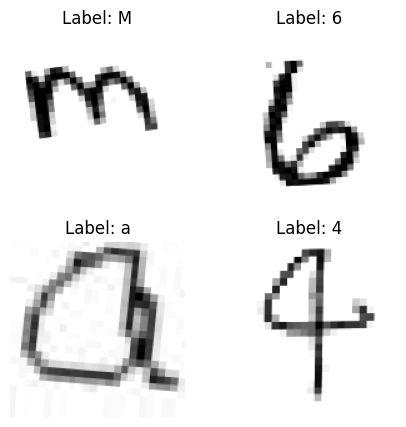

Batch shape: (64, 140, 140, 1)
Labels shape: (64, 89)
Labels: [ 0 43 81 47 29 72 44 64 31 73 53  1 64 57 48 15 26 26  6 76 59 10 50 72
 31 59 69 26  5 42 55 35 17 30 79 25 86 14 62 27 84 51 86  4 43 78  1 63
 55 60 63 51 43 85 57  0 88 47 16 59 40  5 84 60]


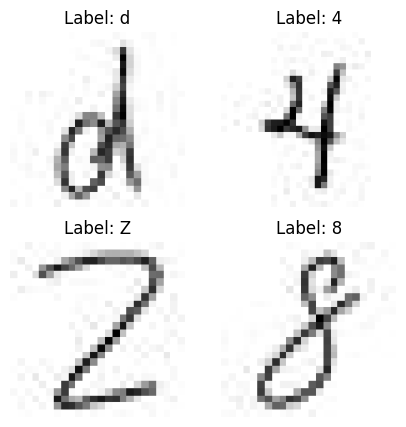

Batch shape: (64, 140, 140, 1)
Labels shape: (64, 89)
Labels: [32  1  4 62 45 10 39 10 86 46 47 77 56 14 70 44 46 72 61 16 44 64 44 70
  9 75  1 47 17  1 68 40 39 57 43 42 41 59 74 43 85 18 70 86 69  1 45  1
  4 43 38 48 68  2 45 36 45  7 10 48 43 80 38 70]


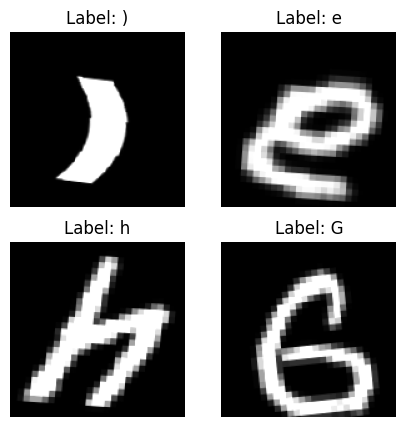

Batch shape: (64, 140, 140, 1)
Labels shape: (64, 89)
Labels: [71  5 42 43 25 58 52 13 41 71 47 75 23 43 20 74 71 39 70 79 68 42 51 39
 74 75 10 70 43 45 41 43 59 42 42 47 87 45 43 69 85 47 10  4 76 46 39 45
 41 75 48 74 10 74 47 48 44 42 42 14 25  0 40 73]


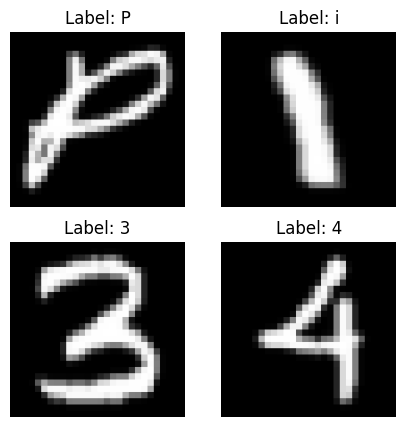

In [11]:
# Debugging generator output
def debug_batch(generator, map):
    """
    Extracts a batch of images from the generator, prints batch information,
    and displays 4 sample images.
    """
    # Get a batch of images and labels
    batch = next(generator)
    images, labels = batch
    
    # Print batch information
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {np.argmax(labels, axis=1)}")
    
    # Display 4 sample images
    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {ascii_convert(int(decode_label(np.argmax(labels[i]), char_to_num)))}")
        plt.axis("off")
    plt.show()

debug_batch(train_generator, char_to_num)
debug_batch(validation_generator, char_to_num)
debug_batch(fine_train_generator, char_to_num)
debug_batch(fine_validation_generator, char_to_num)


# Defining Our Math-Vision Model

After much expermenting and researching I have decided to give Residual Block a try.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters, kernel_size=3, strides=1, activation='relu', dropout=0.1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation(activation)(x)

    if dropout:
        x = layers.Dropout(dropout)(x)
        
    return x


First things first, we define our input shape and number of classes.

In [10]:
# defining input and number of classes.
input_shape = TARGET_SIZE + (1,)
num_classes = len(char_to_num)
print(num_classes)

89


We will now define our model.

In [11]:
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = residual_block(x, 256, dropout=0.15)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = residual_block(x, 512, dropout=0.20)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
      
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

math_vision_model = build_model(input_shape, num_classes)


Here's the summary of our model

In [15]:
math_vision_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140, 140, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 140, 140, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 140, 140, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

We are using focal loss, as it helps the model distinguish overlapping features in the classes.

In [32]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = backend.epsilon()
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = backend.clip(y_pred, epsilon, 1. - epsilon)
        
        # Ensure y_true and y_pred are reshaped correctly
        y_true = tf.reshape(y_true, [-1, tf.shape(y_pred)[-1]])
        
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        fl = - alpha_t * backend.pow((1 - p_t), gamma) * backend.log(p_t)
        
        return backend.mean(backend.sum(fl, axis=-1))
    return focal_loss_fixed

Defining custom callbacks.

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }

    def on_epoch_end(self, epoch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))


# Custom early stopping based on training loss and accuracy
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_loss') < 0.05 and logs.get('val_accuracy') > 0.95:
            print("Training loss < 5% and accuracy > 95% - stopping training")
            self.model.stop_training = True



Initializing callbacks.

In [19]:
# Define the callbacks
checkpoint = ModelCheckpoint(
    'checkpoints/math-vision-resnet_-checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min'
)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7
)
traininghistory = TrainingHistory()

callbacks = [checkpoint, early_stopping, reduce_lr, traininghistory]

Compiling the Model with adam and focal loss of alpha=0.5 and gamma=2.

In [1166]:
optimizer = Adam(learning_rate=0.0001)

# Compile the model
math_vision_model.compile(
    optimizer=optimizer,
    loss=focal_loss(gamma=2, alpha=0.5),
    metrics=['accuracy']
)

# Training Math-Vison Model

Setting the mixed prescision policy to mixed float16 (this is not supported by all GPUs and TPUs)

In [20]:
# Using mixed precision training helps in speeding up training on stronger GPUs
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


If the model doesn't work anymore set it back to float32.

In [665]:
mixed_precision.set_global_policy('float32')

We will train our model for 75 epochs with early stopping if validation reaches a plateau.

In [1168]:
EPOCHS = 75

# Train the model
history = math_vision_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps= validation_generator.samples // validation_generator.batch_size,
    epochs=EPOCHS,
    verbose=1,
    workers=24,
    callbacks=callbacks
)


Epoch 1/75
10305/10305 [==============================] - 1061s 102ms/step - loss: 1.0621 - accuracy: 0.7180 - val_loss: 0.5145 - val_accuracy: 0.7108 - lr: 1.0000e-04
Epoch 2/75
10305/10305 [==============================] - 1045s 101ms/step - loss: 0.3043 - accuracy: 0.8180 - val_loss: 0.3101 - val_accuracy: 0.8092 - lr: 1.0000e-04
Epoch 3/75
10305/10305 [==============================] - 1047s 102ms/step - loss: 0.2491 - accuracy: 0.8320 - val_loss: 0.3271 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 4/75
10305/10305 [==============================] - 1045s 101ms/step - loss: 0.2458 - accuracy: 0.8379 - val_loss: 0.3127 - val_accuracy: 0.8056 - lr: 1.0000e-04
Epoch 5/75
10305/10305 [==============================] - 1047s 102ms/step - loss: 0.2300 - accuracy: 0.8416 - val_loss: 0.5905 - val_accuracy: 0.6273 - lr: 1.0000e-04
Epoch 6/75
10305/10305 [==============================] - 1047s 101ms/step - loss: 0.1779 - accuracy: 0.8626 - val_loss: 0.1900 - val_accuracy: 0.8423 - lr: 2.0

# Plotting the Metrics


We will plot our model's accuracy and loss per epoch to obtain a graph.

In [ ]:
# Plot training & validation CER values
def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'r', label='Training loss')
    plt.plot(epochs, history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['accuracy'], 'r', label='Training accuracy')
    plt.plot(epochs, history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history.history)

# Fine tuning Math-vision model

Let's save this model and later use it for fine tuning.

In [29]:
math_vision_save_path = 'models/math-vision-resnet_model.h5'

In [ ]:

math_vision_model.save(math_vision_save_path)

Let's load the model.

In [33]:
math_vision_fine_tune = load_model(math_vision_save_path, custom_objects={'focal_loss_fixed': focal_loss(gamma=2, alpha=0.25)})

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


Lets setup the callbacks once again.

In [1192]:
checkpoint_path = "checkpoints/resnet-math-vision-fine-tuning.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
custom_early_stopping = CustomEarlyStopping()

training_history = TrainingHistory()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)

We need to unfreeze some of the layer for training.

In [1173]:
for layer in math_vision_fine_tune.layers[-100:]:
    layer.trainable = True

Now let's fit this model with our fine tuining dataset.

In [1193]:
EPOCHS = 15

optimizer = math_vision_fine_tune.optimizer
# Print the current learning rate
print(f"Current learning rate: {tf.keras.backend.get_value(optimizer.learning_rate)}")

# Set a new learning rate
new_learning_rate = 0.00001
tf.keras.backend.set_value(optimizer.learning_rate, new_learning_rate)

# Train the model
fine_tune_history = math_vision_fine_tune.fit(
    fine_train_generator,
    validation_data=fine_validation_generator,
    steps_per_epoch = fine_train_generator.samples // fine_train_generator.batch_size,
    validation_steps= 0.75*fine_validation_generator.samples // fine_validation_generator.batch_size,
    epochs=EPOCHS,
    verbose=1,
    workers=24,
    callbacks=[checkpoint, early_stopping, custom_early_stopping, training_history, reduce_lr]
)

Current learning rate: 1.0000000116860974e-07
Epoch 1/15
1631/1631 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.8085
Epoch 1: val_loss improved from inf to 0.24271, saving model to checkpoints\resnet-math-vision-fine-tuning.h5
1631/1631 [==============================] - 168s 102ms/step - loss: 0.1548 - accuracy: 0.8085 - val_loss: 0.2427 - val_accuracy: 0.7165 - lr: 1.0000e-05
Epoch 2/15
1631/1631 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.8594
Epoch 2: val_loss improved from 0.24271 to 0.22152, saving model to checkpoints\resnet-math-vision-fine-tuning.h5
1631/1631 [==============================] - 166s 101ms/step - loss: 0.1134 - accuracy: 0.8594 - val_loss: 0.2215 - val_accuracy: 0.7390 - lr: 1.0000e-05
Epoch 3/15
1631/1631 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.8721
Epoch 3: val_loss improved from 0.22152 to 0.21491, saving model to checkpoints\resnet-math-vision-fine-tuning.h5
1631/1631 [===

Let's plot this now.

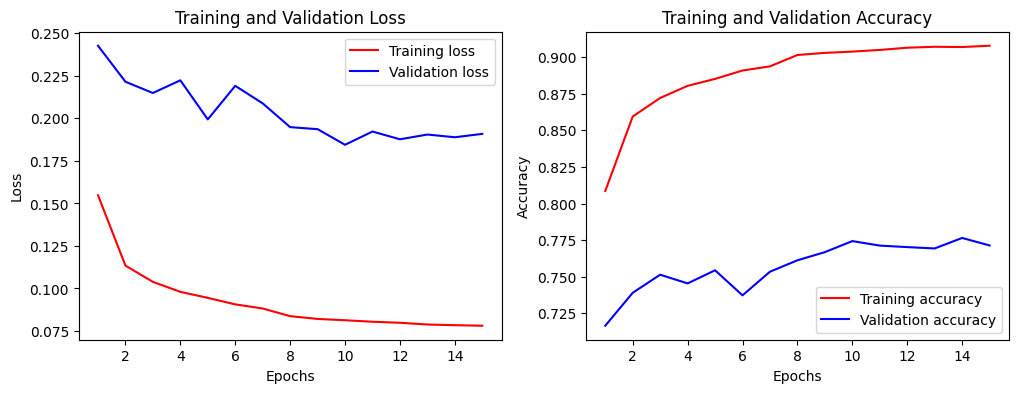

In [1194]:
plot_training_history(fine_tune_history.history)

Let's save our tuned model.

In [34]:
fine_math_vision_save_path = 'models/math-vision-post-tuning-resnet.h5'

In [1195]:

math_vision_fine_tune.save(fine_math_vision_save_path)

In [35]:
math_vision_fine_tune = load_model(fine_math_vision_save_path, custom_objects={'focal_loss_fixed': focal_loss(gamma=2, alpha=0.25)})

Here's the path to both of them:

In [60]:
print(f"Math Vision model saved to: {math_vision_save_path}")
print(f"Tuned Math Vision model saved to: {fine_math_vision_save_path}")

Math Vision model saved to: models/math-vision-resnet_model.h5
Tuned Math Vision model saved to: models/math-vision-post-tuning-resnet.h5


# Testing our model

We will now test our model.

In [36]:
TEST_DIR = 'images/test'
LABELS_CSV = os.path.join(TEST_DIR, "english.csv")
RESNET_MODEL_PATH = math_vision_save_path
TUNED_RESNET_MODEL_PATH = fine_math_vision_save_path
NUM_CLASSES = num_classes

SIZE = TARGET_SIZE

num_to_char = {v: k for k, v in char_to_num.items()}

Function to convert Labels.


In [37]:
def convert_label(label):
    spec_char = {
    '+': 'add',
    '-': 'sub',
    '=': 'eq',
    '÷': 'div',
    '*': 'mul',
    '(': 'open_curve',
    ')': 'close_curve',
    '\\': 'fwd_slash',
    '/': 'back_slash',
    ':': 'col',
    ';': 'sem',
    '%': 'percent',
    '|': 'mod',
    '[': 'open_sqaure',
    ']': 'close_sqaure',
    '<': 'open_sharp',
    '>': 'close_sharp',
    ',': 'com',
    '.': 'dot',
    '^': 'power',
    }
    
    #spec_char = {v:k for (k, v) in spec_char.items()}
    
    if label.islower():
        return f"{label}_small"
    elif label.isupper():
        return f"{label}_cap"
    elif label in spec_char:
        return spec_char[f'{label}']
    else:
        return label

def load_labels_as_dict(csv_path):
    df = pd.read_csv(csv_path)
    df['label'] = df['label'].apply(convert_label)
    labels_dict = {os.path.basename(row['image']).strip().lower(): row['label']
                   for _, row in df.iterrows()}
    return labels_dict

Load Models

In [38]:
# Load models
resnet_math_vision = load_model(RESNET_MODEL_PATH, custom_objects={'focal_loss_fixed': focal_loss(gamma=2, alpha=.25)})
tuned_resnet_math_vision = load_model(TUNED_RESNET_MODEL_PATH, custom_objects={'focal_loss_fixed': focal_loss(gamma=2, alpha=.25)})

Load and Preprocess Images

In [39]:
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=SIZE).convert('L')
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

Compare Predictions

1/1 [==============================] - 0s 21ms/step


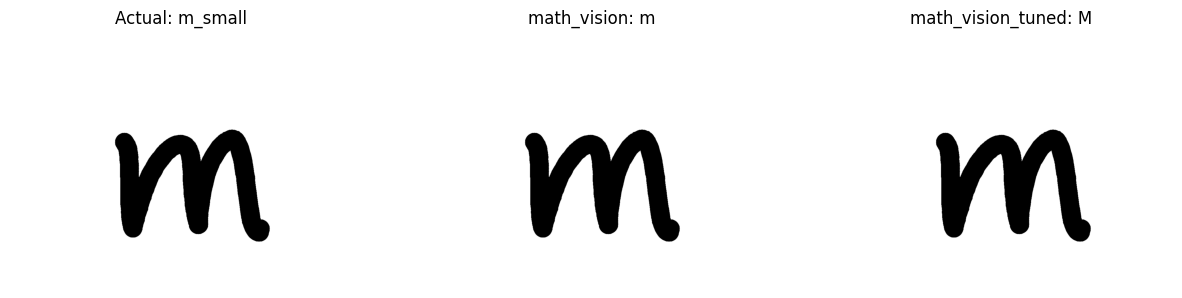

1/1 [==============================] - 0s 28ms/step


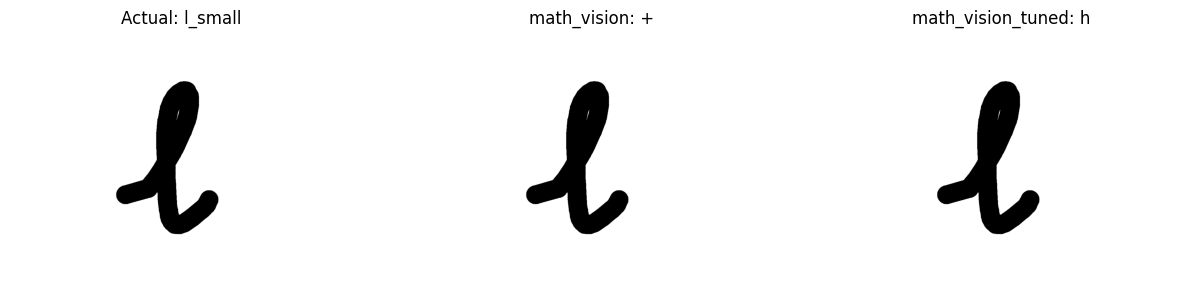

1/1 [==============================] - 0s 20ms/step


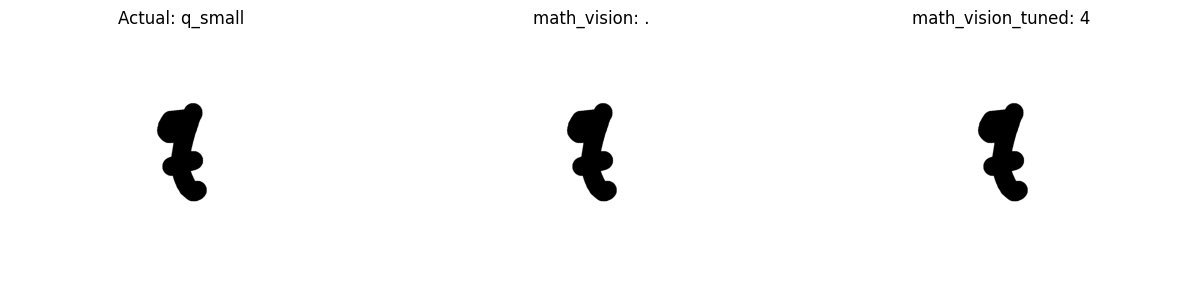

1/1 [==============================] - 0s 27ms/step


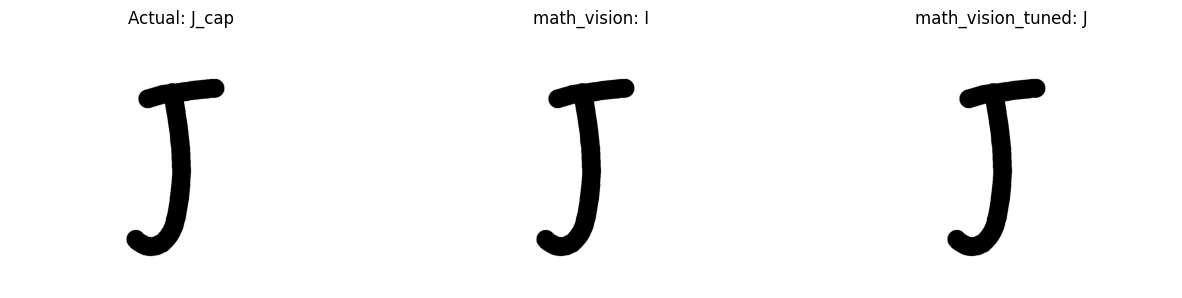

1/1 [==============================] - 0s 21ms/step


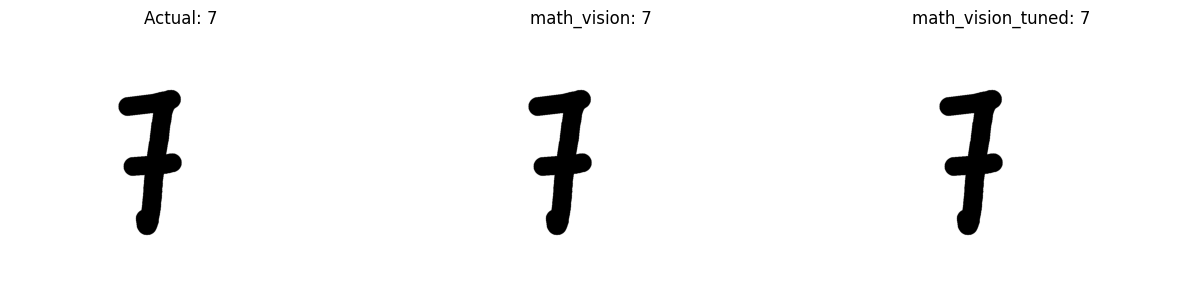

1/1 [==============================] - 0s 21ms/step


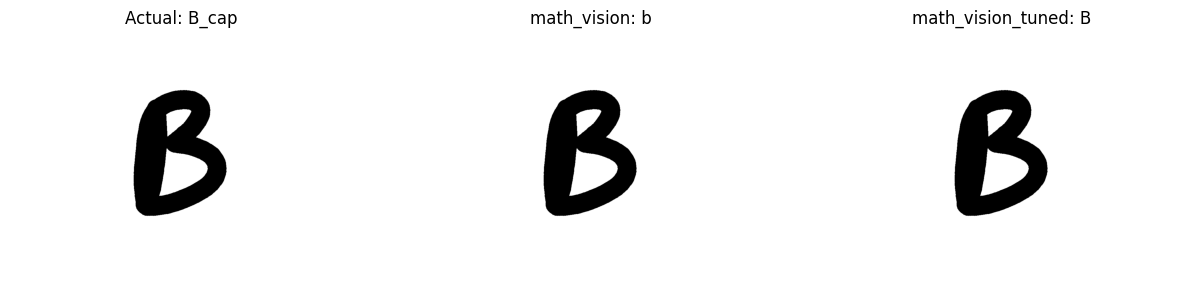

1/1 [==============================] - 0s 20ms/step


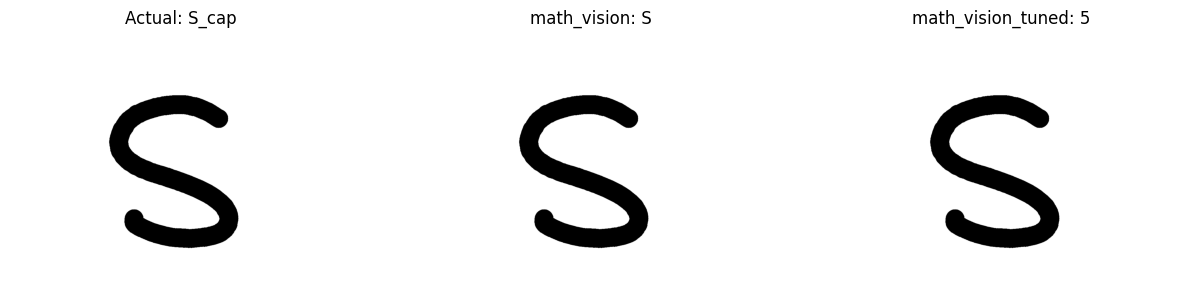

1/1 [==============================] - 0s 22ms/step


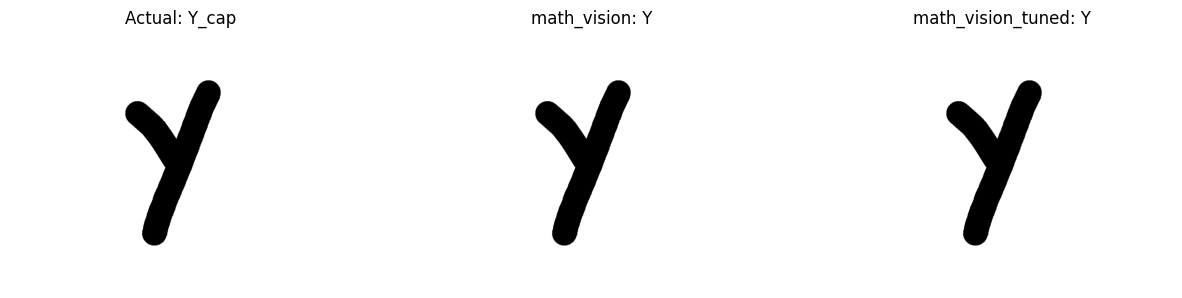

1/1 [==============================] - 0s 22ms/step


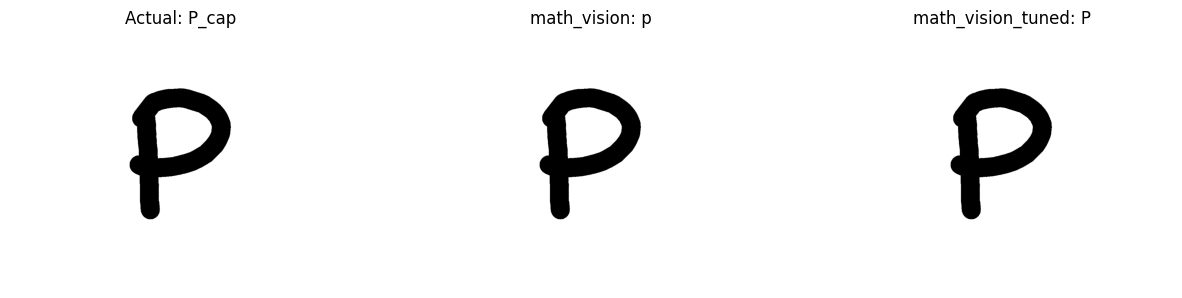

1/1 [==============================] - 0s 22ms/step


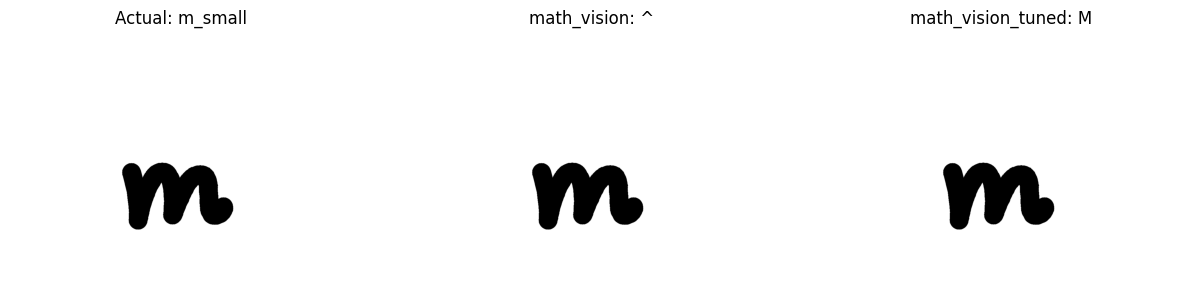

In [48]:
from PIL import UnidentifiedImageError
def compare_models(models, test_dir, labels_dict, num_samples=10):
    all_images = [f for f in os.listdir(test_dir) if f.endswith('.png')]
    available_samples = len(all_images)
    
    # Adjust the number of samples if necessary
    if num_samples > available_samples:
        print(f"Requested {num_samples} samples, but only {available_samples} are available. Adjusting to {available_samples} samples.")
        num_samples = available_samples
    
    selected_images = random.sample(all_images, num_samples)
    
    model_names = list(models.keys())
    results = {model_name: {'correct': 0, 'incorrect': 0} for model_name in model_names}
    
    for img_name in selected_images:
        img_path = os.path.join(test_dir, img_name)
        try:
            img_array = load_and_preprocess_image(img_path)
            img_key = img_name.strip().lower()
            if img_key not in labels_dict:
                print(f"No label found for image: {img_name}")
                continue
            actual_label = labels_dict[img_key]
        except (UnidentifiedImageError, IndexError, PermissionError) as e:
            print(f"Skipping file {img_name} due to error: {e}")
            continue
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, len(models) + 1, 1)
        plt.imshow(load_img(img_path))
        plt.title(f"Actual: {actual_label}")
        plt.axis('off')
        
        for i, (model_name, model) in enumerate(models.items(), 2):
            prediction = model.predict(img_array)
            predicted_label_index = np.argmax(prediction, axis=1)[0]
            predicted_label = list(char_to_num.keys())[list(char_to_num.values()).index(predicted_label_index)]
            predicted_label = convert_label(predicted_label)
            
            plt.subplot(1, len(models) + 1, i)
            plt.imshow(load_img(img_path))
            plt.title(f"{model_name}: {ascii_convert(int(predicted_label))}")
            plt.axis('off')
            
            if predicted_label == actual_label:
                results[model_name]['correct'] += 1
            else:
                results[model_name]['incorrect'] += 1
        
        plt.show()
    
    return results

# Load labels
labels_dict = load_labels_as_dict(LABELS_CSV)

#print("\n",labels_dict)

# Compare models
models = {
    'math_vision': resnet_math_vision,
    'math_vision_tuned': tuned_resnet_math_vision,
    
}

results = compare_models(models, TEST_DIR, labels_dict, num_samples=10)

You can test on any image file that you like inside this dir ''images/test/Img''

In [63]:
for img in os.listdir('images/test/Img/'):
    image = load_and_preprocess_image(os.path.join('images/test/Img/',img))
    prediction = tuned_resnet_math_vision.predict(image)
    predicted_label_index = np.argmax(prediction, axis=1)[0]
    predicted_label = list(char_to_num.keys())[list(char_to_num.values()).index(predicted_label_index)]
    predicted_label = convert_label(predicted_label)
    print(ascii_convert(int(predicted_label)), img)

1/1 [==============================] - 0s 23ms/step
# #.png
1/1 [==============================] - 0s 22ms/step
f $.png
1/1 [==============================] - 0s 24ms/step
* %.png
1/1 [==============================] - 0s 24ms/step
q &.png
1/1 [==============================] - 0s 21ms/step
( (.png
1/1 [==============================] - 0s 22ms/step
) ).png
1/1 [==============================] - 0s 20ms/step
= +.png
1/1 [==============================] - 0s 23ms/step
; ,.png
1/1 [==============================] - 0s 21ms/step
, 0.png
1/1 [==============================] - 0s 21ms/step
1 1.png
1/1 [==============================] - 0s 23ms/step
z 2.png
1/1 [==============================] - 0s 24ms/step
} 3.png
1/1 [==============================] - 0s 23ms/step
4 4.png
1/1 [==============================] - 0s 22ms/step
4 42.png
1/1 [==============================] - 0s 20ms/step
5 5.png
1/1 [==============================] - 0s 23ms/step
G 6.png
1/1 [==============================] - 